In [1]:
import os
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import geopandas as gp
import sklearn.preprocessing

In [9]:
# Read in the CSVs from the data folder

# find files
data_dir = "../data"
files = [os.path.join(data_dir,x) for x in os.listdir("../data") if x.endswith(".txt") or x.endswith(".csv")]

# read as dataframes
p = pd.read_csv(files[0])
q = pd.read_csv(files[1])
et = pd.read_csv(files[2])
ds = pd.read_csv(files[3], sep='\t', header=0)

# set indices as time
p.set_index(p.columns[0], inplace=True)
q.set_index(q.columns[0], inplace = True)
et.set_index(et.columns[0], inplace = True)


ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)
p.index = pd.to_datetime(p.index)
q.index = pd.to_datetime(q.index)
et.index = pd.to_datetime(et.index)

# Change the ds index to be beginning of the month
ds.index += datetime.timedelta(days = 1)

# Merge the dfs
p_q = pd.merge(p,q, left_index=True, right_index=True)
p_q_et = pd.merge(p_q, et, left_index=True, right_index=True)

# Set the timezones to none
p_q_et = p_q_et.tz_localize(None).copy()
ds = ds.tz_localize(None).copy()

# Merge again
df = pd.merge(p_q_et, ds, left_index=True, right_index=True)

# Drop irrelevant columns
df.drop(["region", 'dt'], axis = 1, inplace = True)

In [10]:
df.head()

,trmm,prism,chirps,discharge_cms,modis,gldas,gridmet,s
2001-01-01,1.093282e+07,5.273174e+06,3.062379e+06,368.118400,1.773670e+06,4.593587e+05,1.174011e+06,4580.215098
2001-02-01,1.432065e+07,6.721928e+06,3.510050e+06,504.039040,1.534297e+06,6.572096e+05,1.345984e+06,4580.902281
2001-03-01,6.189033e+06,3.217688e+06,2.264511e+06,903.305920,2.761055e+06,1.421961e+06,2.199432e+06,4581.688633
2001-04-01,7.002581e+06,3.531893e+06,1.728371e+06,393.603520,2.159400e+06,1.913153e+06,2.520901e+06,4582.127895
2001-05-01,2.803792e+05,2.534074e+05,2.999343e+05,262.496736,2.787220e+06,2.552808e+06,2.110090e+06,4581.939481


In [11]:
# Get the area over which precip and ET were calculated over
hu4 = gp.read_file("../shape/cv_hu6.shp")
study_area = hu4.AreaSqKm.values
study_area = study_area * 1000000. # sq km to sq m

# Now convert to the appropriate units

df['q'] = df.discharge_cms*2.628e+6 # convert cms to cubic m/month
df['p'] = df.prism*study_area * 1e-3 # multiply by study area and convert mm to m
df['et_gridmet'] = df.gridmet*study_area * 1e-3 # multiply by study area and convert mm to m
df['et_modis'] = df.modis*study_area * 1e-3 # multiply by study area and convert mm to m
df['s_m3'] = df.s * 1.23348e+9 # convert from million acre ft to cubic m 

In [12]:
# df['ds_mod'] = df.p - df.et_modis - df.q
# df['ds_gridmet'] = df.p - df.et_gridmet - df.q

df['ds'] = df.p - df.et_gridmet - df.q

In [13]:
df.head()

,trmm,prism,chirps,discharge_cms,modis,gldas,gridmet,s,q,p,et_gridmet,et_modis,s_m3,ds
2001-01-01,1.093282e+07,5.273174e+06,3.062379e+06,368.118400,1.773670e+06,4.593587e+05,1.174011e+06,4580.215098,9.674152e+08,2.240969e+14,4.989258e+13,7.537658e+13,5.649604e+12,1.742033e+14
2001-02-01,1.432065e+07,6.721928e+06,3.510050e+06,504.039040,1.534297e+06,6.572096e+05,1.345984e+06,4580.902281,1.324615e+09,2.856653e+14,5.720102e+13,6.520383e+13,5.650451e+12,2.284630e+14
2001-03-01,6.189033e+06,3.217688e+06,2.264511e+06,903.305920,2.761055e+06,1.421961e+06,2.199432e+06,4581.688633,2.373888e+09,1.367438e+14,9.347042e+13,1.173380e+14,5.651421e+12,4.327101e+13
2001-04-01,7.002581e+06,3.531893e+06,1.728371e+06,393.603520,2.159400e+06,1.913153e+06,2.520901e+06,4582.127895,1.034390e+09,1.500967e+14,1.071321e+14,9.176916e+13,5.651963e+12,4.296365e+13
2001-05-01,2.803792e+05,2.534074e+05,2.999343e+05,262.496736,2.787220e+06,2.552808e+06,2.110090e+06,4581.939481,6.898414e+08,1.076919e+13,8.967360e+13,1.184500e+14,5.651731e+12,-7.890510e+13


/Users/aakashahamed/anaconda3/envs/tc/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


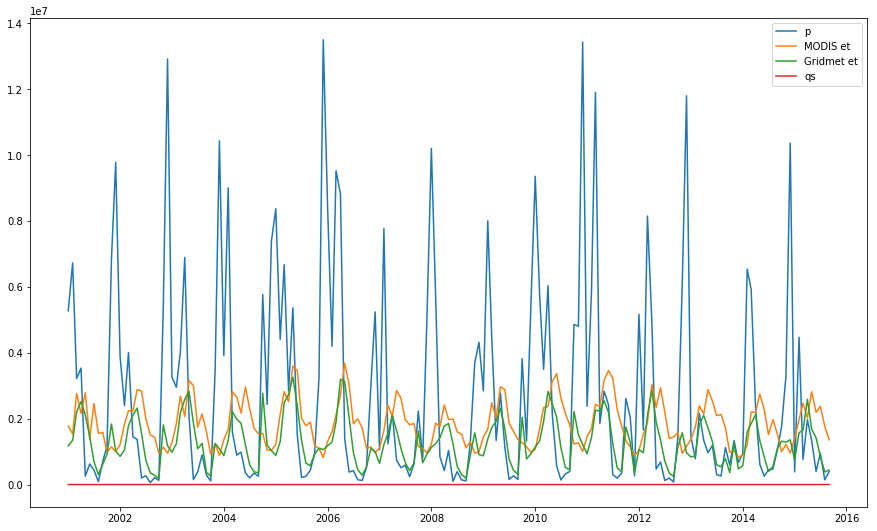

In [14]:
plt.figure(figsize = (15, 9))

plt.plot(df.index,df['prism'], label = "p")
plt.plot(df.index,df['modis'], label = "MODIS et")
plt.plot(df.index,df['gridmet'], label = "Gridmet et")
plt.plot(df.index,df['discharge_cms'], label = "qs")

plt.legend()
plt.show()

In [25]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year+1)

sums = {}

for year in years:
    year_df = df[df.index.year == year]
    year_sum = np.sum(year_df['ds'])
    sums[year] = year_sum
    

In [78]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year+1)

sums = {}

startmonth = 11

for year in years[:1]:
        
    ydf1 = df.iloc[df.index.year == year]
    mdf1 = ydf.iloc[ydf.index.month == startmonth]
    
    print(mdf1.index)
    
    ydf2 = df.iloc[df.index.year == year+1]
    mdf2 = ydf1.iloc[ydf1.index.month == startmonth]

    t = df.loc[mdf1.index.difference(mdf.index)]
    
#     print(t)
    
#     hyr = df.iloc(mdf:mdf+12)
#     print(mdf)
    start_year_df = df[df.index.year == year]
#     idx = year_df[start_year_df.index.month == startmonth]
    
    nextyear_df = df[df.index.year == year+1]
    monthidx = year_df.loc[year_df.index.month == startmonth-1]
    
    


#     print(monthidx)

DatetimeIndex(['2001-11-01'], dtype='datetime64[ns]', freq=None)


In [ ]:
integer_location = np.where(df.index == 3454)[0][0]
start = max(0, integer_location - 55)
end = max(1, integer_location)
dfRange = df.iloc[start:end]

In [ ]:
df.loc[np.r_[0:5, 10:15, 20:25], :]

In [26]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=1),  freq='Y')
ds_df = pd.DataFrame(sums.values(), index = dt_idx)
ds_df.columns = ["ds"]

ds_df.head()

,ds
2001-12-31,9.520963e+14
2002-12-31,7.666406e+14
2003-12-31,7.630072e+14
2004-12-31,7.359269e+14
2005-12-31,1.232541e+15


In [27]:
window = 3
ds_df['s'] = ds_df['ds'].rolling(window, win_type='triang').mean()


In [28]:
mms = sklearn.preprocessing.MinMaxScaler()

scaled = []

for i in [ds_df['ds'],ds_df['s'],df['s_m3']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


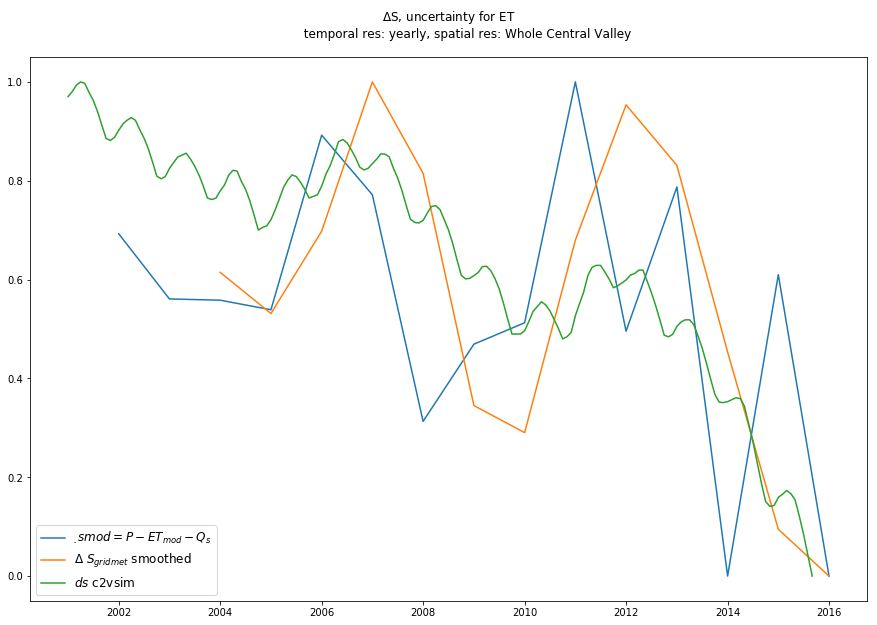

In [29]:
plt.figure(figsize=(15,10))

plt.title("""$\Delta$S, uncertainty for ET 
          temporal res: yearly, spatial res: Whole Central Valley
          """)

plt.plot(ds_df.index, scaled[0], label = "$\d{smod} = P - ET_{mod} - Q_s$")

plt.plot(ds_df.index[window-1:], scaled[1], label = '$\Delta$ $S_{gridmet}$ smoothed')

plt.plot(df.index, scaled[2], label = "$ds$ c2vsim")

plt.legend(loc="lower left", fontsize = 'large')

plt.show()